In [4]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer,make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import os 
os.chdir(r"D:\kaggla_comp\loan")

train = pd.read_csv("train_ctrUa4K.csv", index_col=0)
test = pd.read_csv("test_lAUu6dG.csv", index_col=0)

X = train.drop('Loan_Status', axis=1)
y = train['Loan_Status']

print(X.isnull().sum())

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
dtype: int64


# Handling Missing Values with Column Transformer

In [11]:
# Create a SimpleImputer for categorical features using the most frequent strategy
imp_cat = SimpleImputer(strategy='most_frequent')

# Create a SimpleImputer for numerical features using the median strategy
imp_med = SimpleImputer(strategy='median')

# Create a ColumnTransformer to handle missing values in both categorical and numerical columns
ct_impute = make_column_transformer(
    (imp_cat, make_column_selector(dtype_include=object)),  # Apply most_frequent imputation to categorical columns
    (imp_med, make_column_selector(dtype_exclude=object)),  # Apply median imputation to numerical columns
    verbose_feature_names_out=False  # Suppress verbose feature names
)

# Set the output format of the ColumnTransformer to pandas DataFrame
ct_impute = ct_impute.set_output(transform='pandas')

# Encoding Categorical Features with One-Hot Encoding

In [12]:
# Create a OneHotEncoder object with sparse_output set to False
ohc = OneHotEncoder(sparse_output=False)

# Create a ColumnTransformer to apply one-hot encoding to categorical columns and pass through numerical columns
ct_enc = make_column_transformer(
    (ohc, make_column_selector(dtype_include=object)),  # Apply one-hot encoding to categorical columns
    ("passthrough", make_column_selector(dtype_exclude=object)),  # Pass through numerical columns
    verbose_feature_names_out=False  # Suppress verbose feature names
)

# Set the output format of the ColumnTransformer to pandas DataFrame
ct_enc = ct_enc.set_output(transform='pandas')

# Preprocessing Pipeline

In [7]:
# Create a preprocessing pipeline with imputation and encoding steps
pipe_pp = Pipeline([
    ('IMP', ct_impute),  # Imputation step using ct_impute
    ('ENC', ct_enc)      # Encoding step using ct_enc
])

# Fit and transform the input DataFrame X using the preprocessing pipeline
X_imp_enc = pipe_pp.fit_transform(X)

# Tuning Decision Tree Hyperparameters

In [13]:
# Define the hyperparameter grid to search
params = {
    'max_depth': [2, 5, 7, 10, 13, None],
    'min_samples_split': [2, 5, 7, 10, 13],
    'min_samples_leaf': [1, 5, 7, 10, 13]
}

# Create a Decision Tree Classifier with a fixed random state
dtc = DecisionTreeClassifier(random_state=24)

# Create a StratifiedKFold cross-validator with 5 splits
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=24)

# Create a GridSearchCV object with the specified parameters
gcv_tree = GridSearchCV(
    dtc,
    param_grid=params,
    cv=kfold,
    verbose=3,
    scoring='accuracy'
)

# Fit the GridSearchCV object to the preprocessed data X_imp_enc and target y
gcv_tree.fit(X_imp_enc, y)

# Print the best hyperparameters and best score
print('Best Hyperparameters:', gcv_tree.best_params_)
print('Best Score:', gcv_tree.best_score_)

# Get the best estimator (Decision Tree Classifier) from the GridSearchCV object
best_tree = gcv_tree.best_estimator_

Fitting 5 folds for each of 150 candidates, totalling 750 fits
[CV 1/5] END max_depth=2, min_samples_leaf=1, min_samples_split=2;, score=0.805 total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_leaf=1, min_samples_split=2;, score=0.797 total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_leaf=1, min_samples_split=2;, score=0.780 total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_leaf=1, min_samples_split=2;, score=0.837 total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_leaf=1, min_samples_split=2;, score=0.811 total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_leaf=1, min_samples_split=5;, score=0.805 total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_leaf=1, min_samples_split=5;, score=0.797 total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_leaf=1, min_samples_split=5;, score=0.780 total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_leaf=1, min_samples_split=5;, score=0.837 total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_leaf=1, 

# Making Predictions and Generating Submission

In [9]:
# Transform the test data using the preprocessing pipeline
test_imp_enc = pipe_pp.transform(test)

# Use the best Decision Tree Classifier to make predictions on the test data
prediction = best_tree.predict(test_imp_enc)

# Load the sample submission file
submit = pd.read_csv("sample_submission_49d68Cx.csv")

# Update the 'Loan_Status' column in the submission file with the predictions
submit['Loan_Status'] = prediction

# Save the updated submission file
submit.to_csv("sbt_tr_27_jun.csv", index=False)

# Visualizing Feature Importances

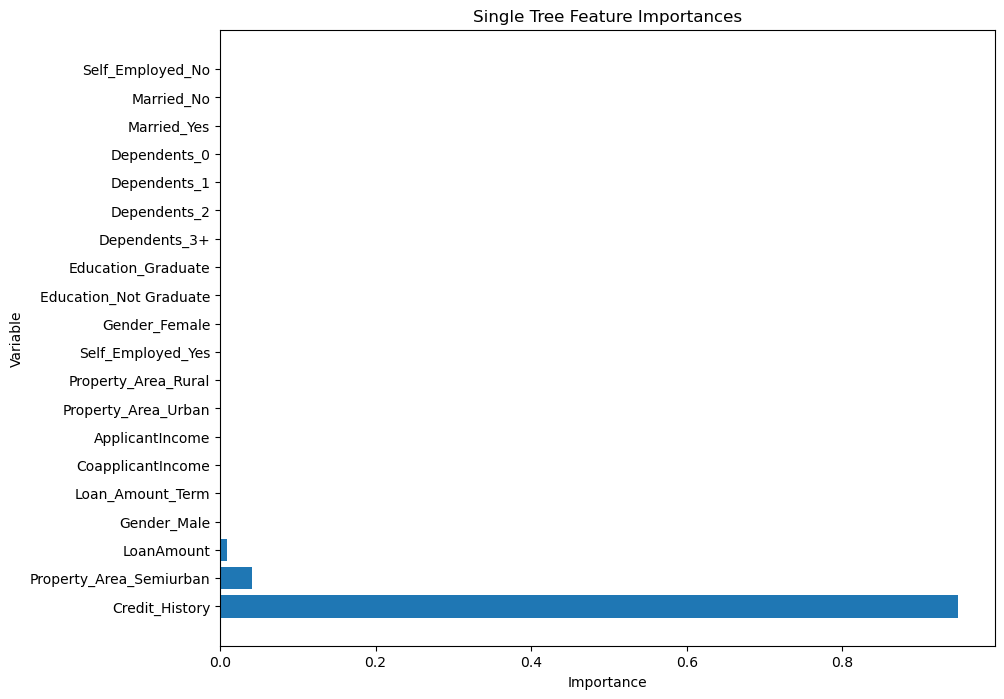

In [14]:
# Create a DataFrame with the feature names and their importances
pd_imp = pd.DataFrame({
    'var': list(X_imp_enc.columns),
    'imp': best_tree.feature_importances_
})

# Sort the DataFrame by the importance values in descending order
pd_imp.sort_values(by='imp', inplace=True, ascending=False)

# Create a horizontal bar plot of the feature importances
plt.figure(figsize=(10, 8))
plt.barh(pd_imp['var'], pd_imp['imp'])
plt.ylabel("Variable")
plt.title("Single Tree Feature Importances")
plt.xlabel("Importance")
plt.show()